In [1]:
import sys
sys.path.append('../../code/')

In [2]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis

from libs.visuals import quadrants
from libs.metrics import aggregators

Available LLMs: (24): llama-3.3-8b llama-4-scout llama-4-mav gpt-oss-20b gpt-oss-120b qwen3-8b qwen3-14b qwen3-32b qwen3-30b-a3b-2507 qwen3-235b-a22b-2507 gemma-3-12b gemma-3-27b mistral-small-3.2-24b mistral-medium-3 llama-3.1-70b llama-3.3-70b llama-3.1-405b grok-4-fast deepseek-chat-v3.1 deepseek-r1-0528 gemini-2.5-flash gemini-2.5-flash-grounded gemini-2.5-pro gemini-2.5-pro-grounded


/home/espinl/.conda/envs/py311_llmscholar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

In [3]:
BENCHMARKS_PATH = '../../results/interventions/benchmarks/'

PLOTS_PATH = '../../results/interventions/plots'
TABLES_PATH = '../../results/interventions/tables'
LATEX_PATH = '../../results/interventions/latex'

io.validate_path(PLOTS_PATH)
io.validate_path(TABLES_PATH)
io.validate_path(LATEX_PATH)

## Data

In [6]:
PREFIX = 'quadrants'

In [7]:
files = io.get_files(BENCHMARKS_PATH, f'per_attempt_*.csv')
df_per_attempt_all = io.pd.concat([io.read_csv(fn, index_col=0, low_memory=False) for fn in files], ignore_index=True)
df_per_attempt_all.shape

(575005, 15)

In [8]:
# filtering out rag and non-biased prompts
# query = "grounded == True and model in @constants.LLMS_GEMINI and task_name != @constants.EXPERIMENT_TASK_BIASED_TOP_K"
# df_per_attempt = df_per_attempt_all.query(query).copy()
# df_per_attempt.loc[:, 'model'] = df_per_attempt.model.apply(lambda x: x.replace('-grounded', ''))
df_per_attempt = df_per_attempt_all.copy()

# Plots

In [9]:
vis.sns_reset()
vis.sns_paper_style(font_scale=constants.FONT_SCALE)

In [90]:
alpha_ci = 0.05
metric_name_col = 'metric_name'
metric_value_col = 'metric_value'
groupby = ['model', 'metric_name']
cols_order = ['model', 'n','metric_name','mean','std','median','sum','ci','ci_low','ci_high']

## Pairwise

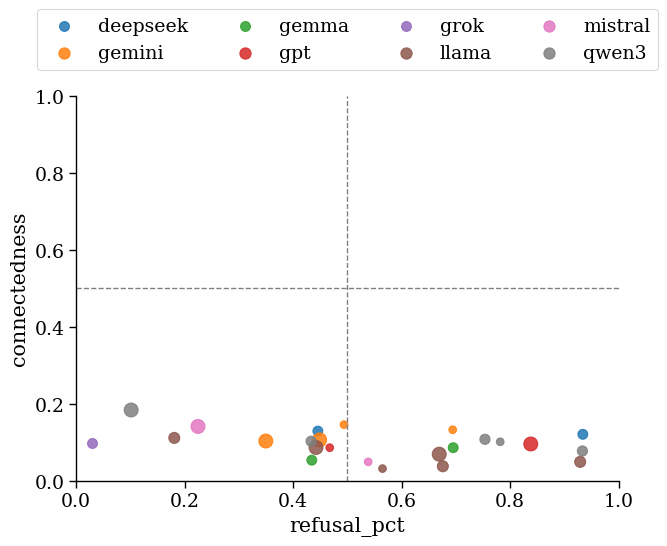

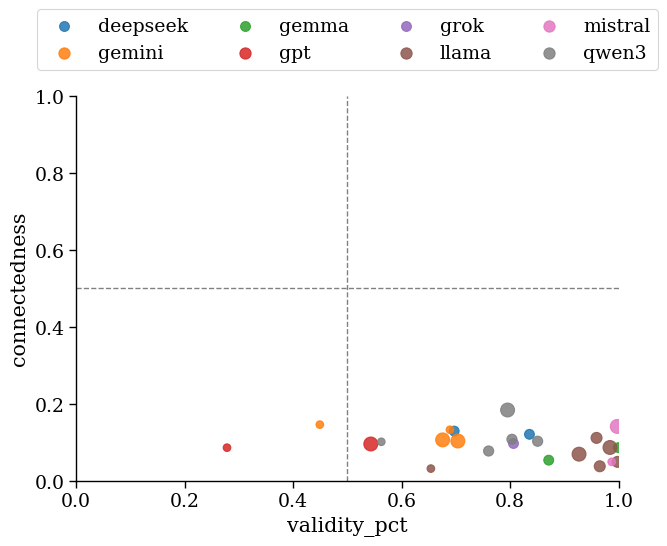

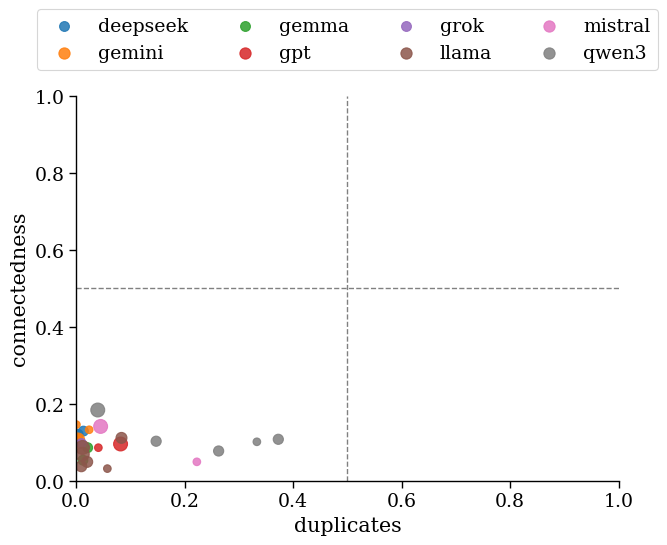

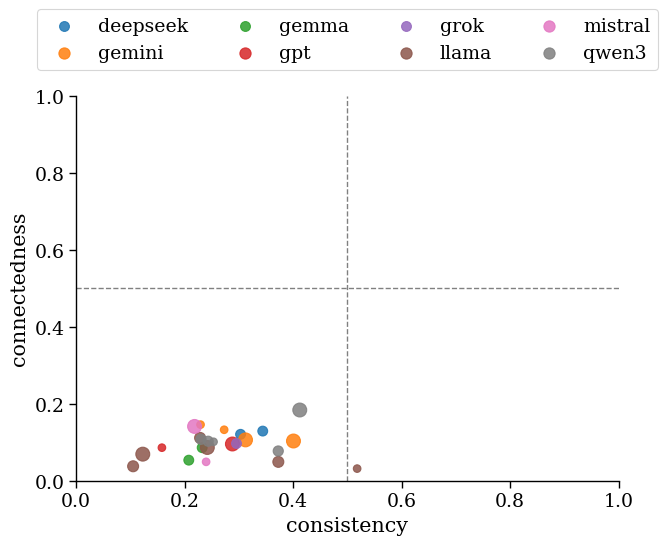

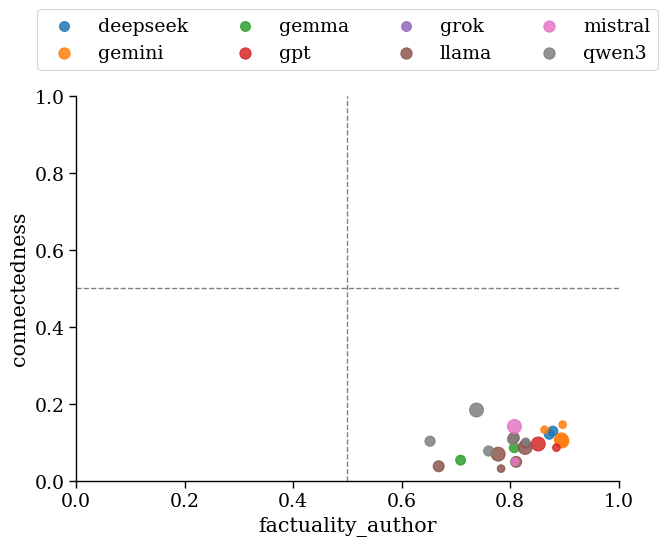

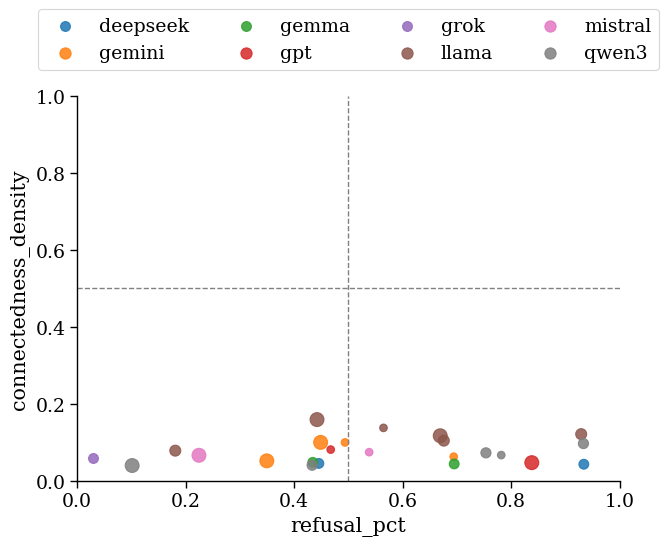

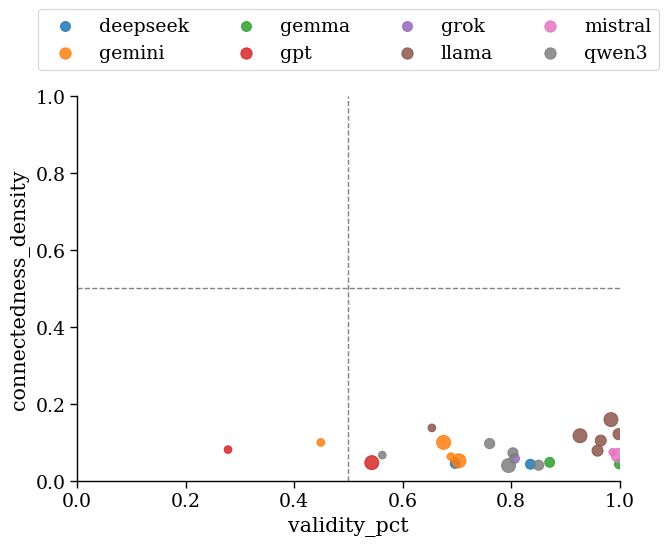

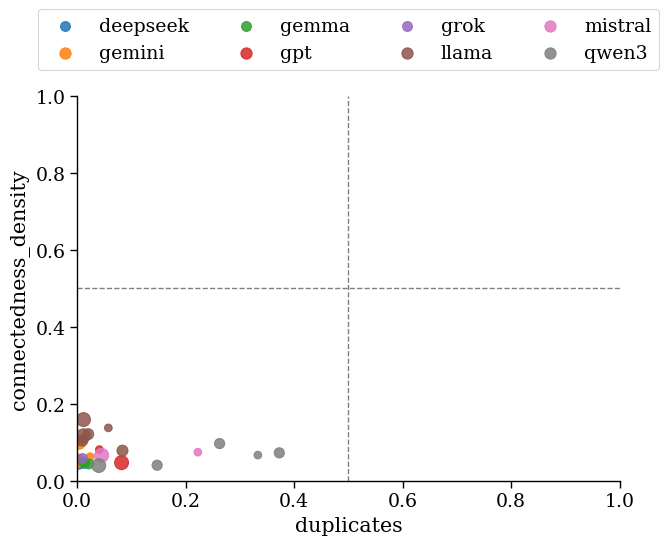

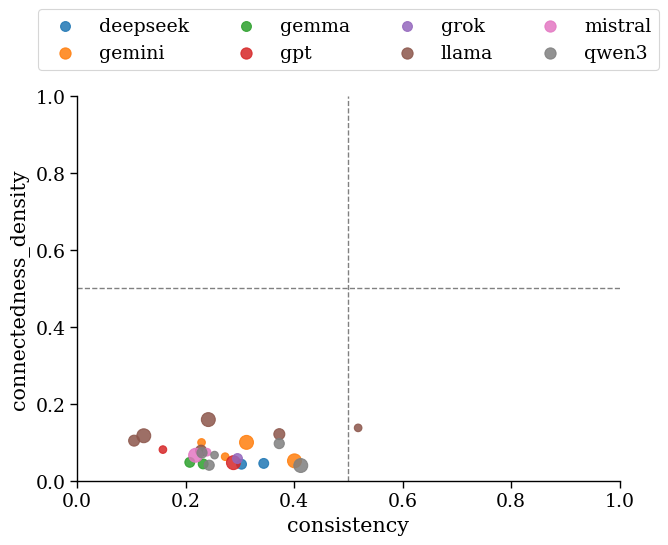

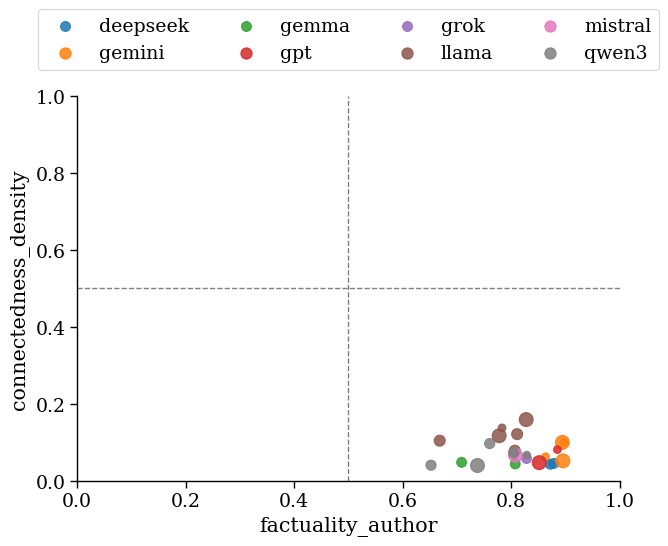

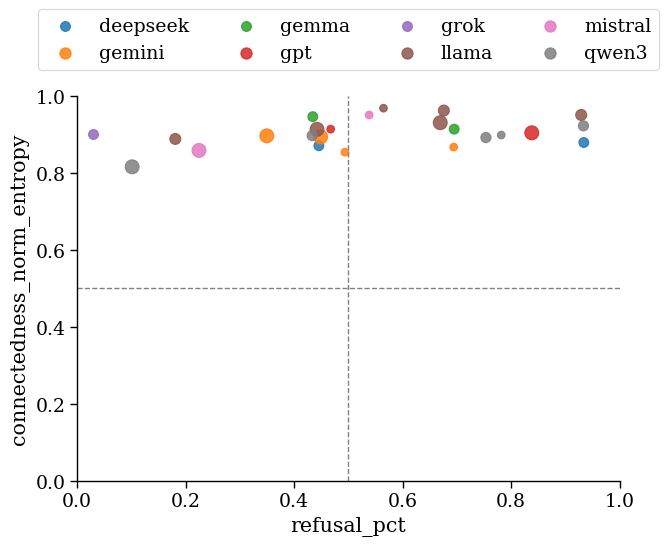

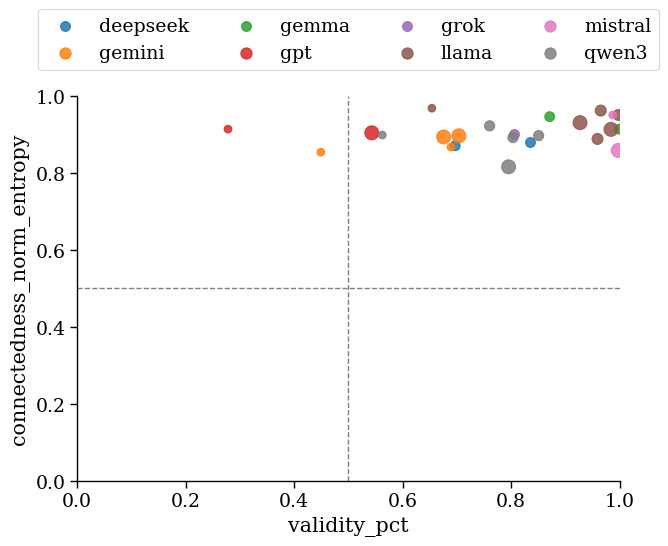

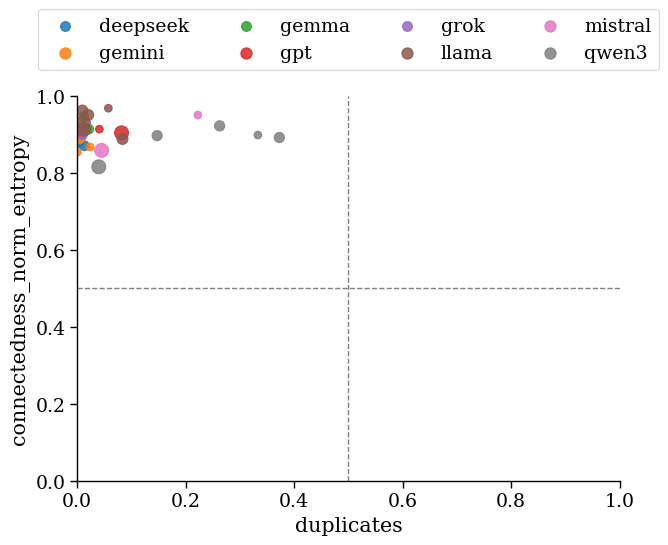

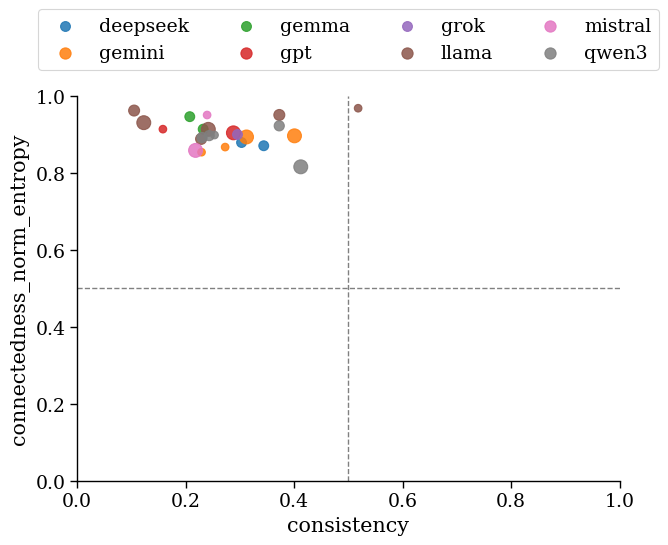

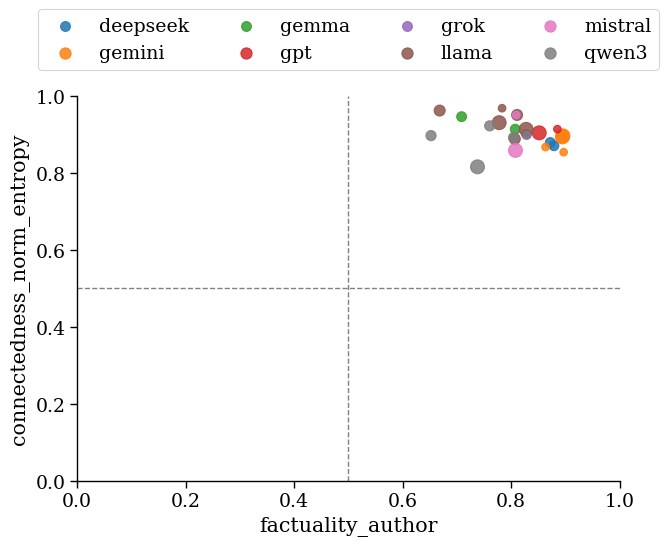

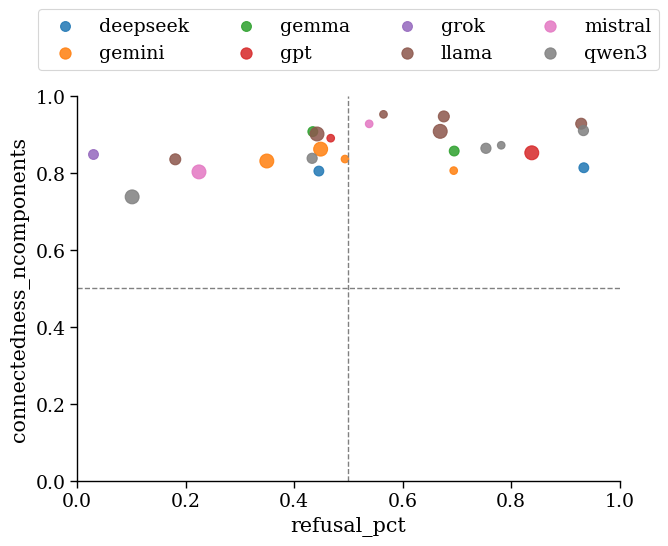

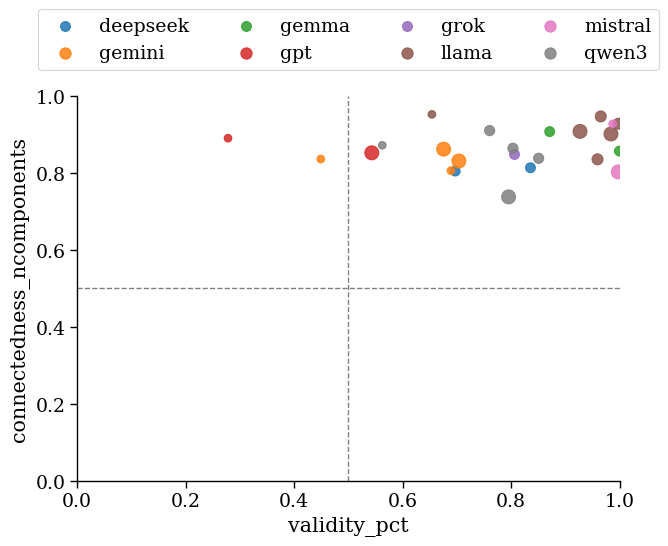

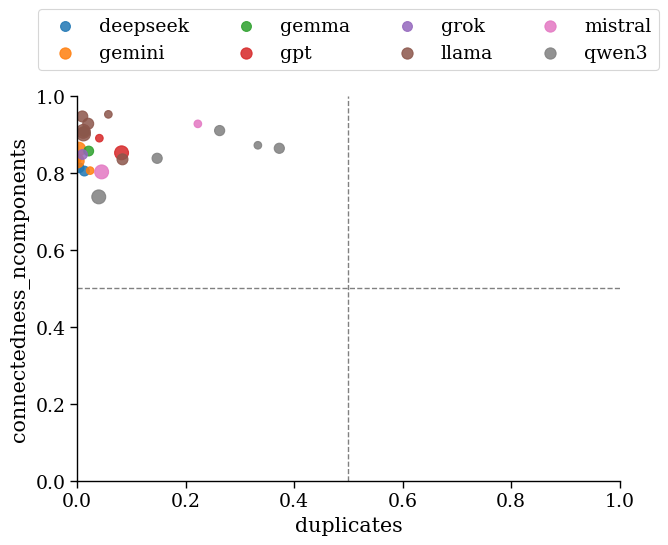

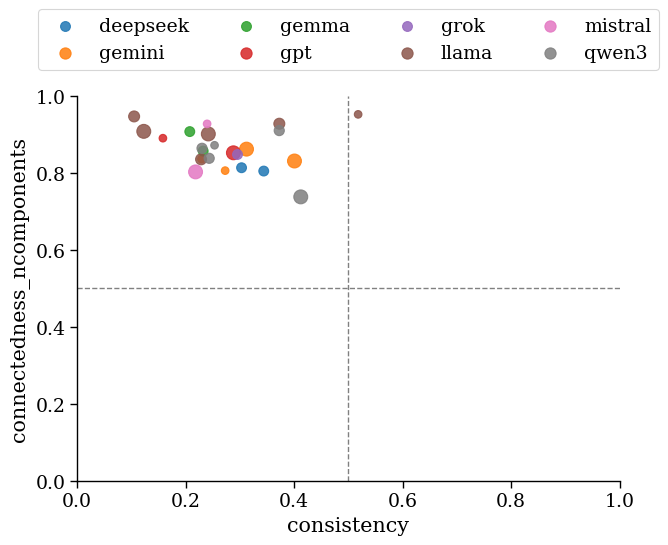

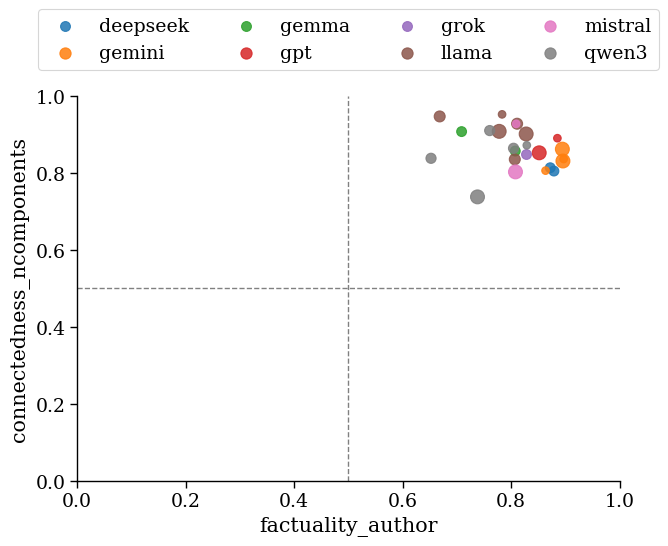

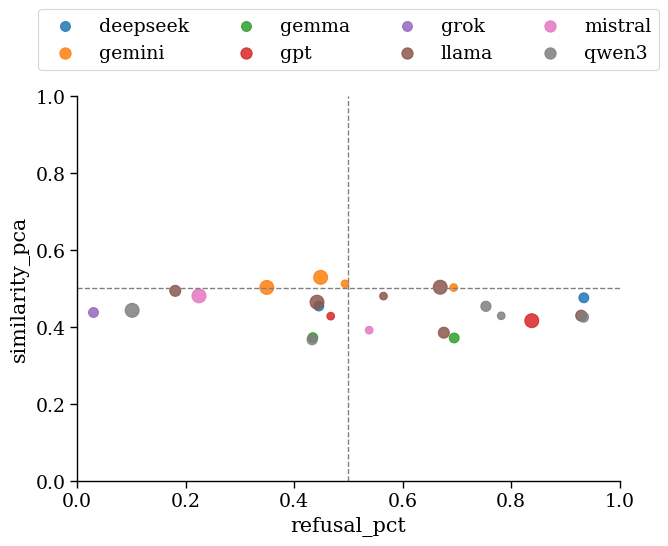

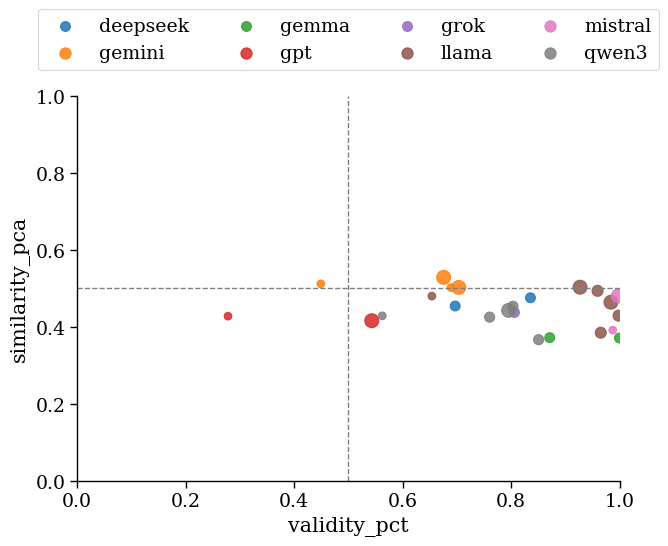

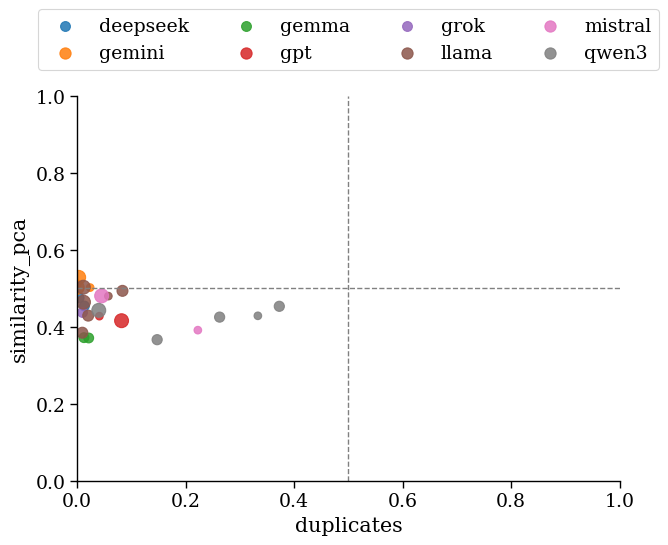

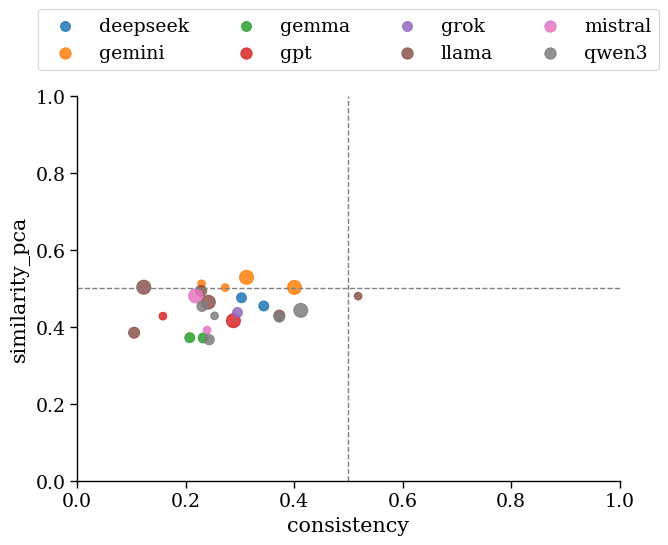

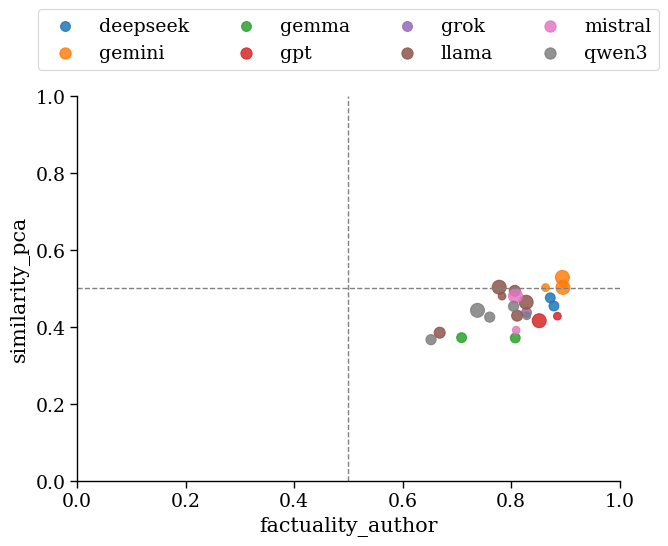

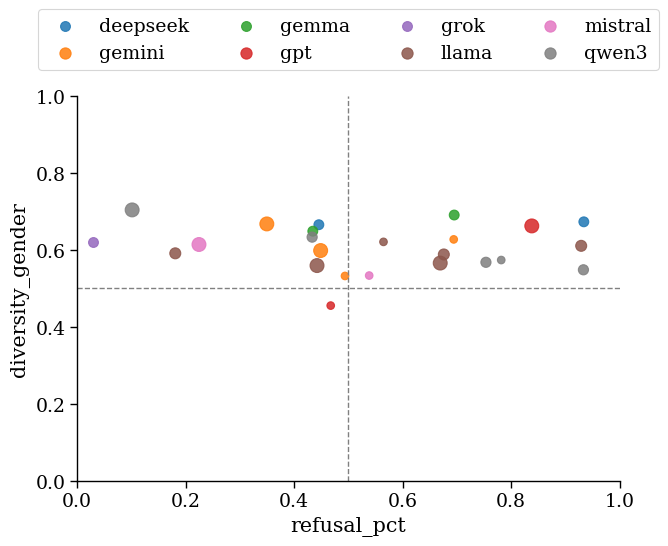

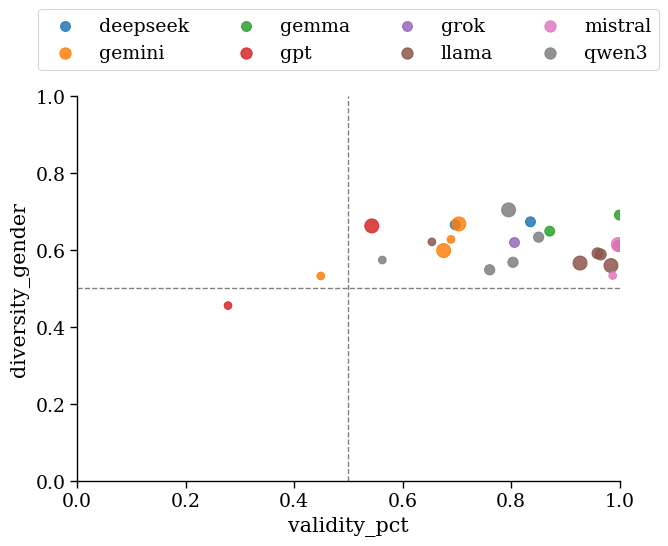

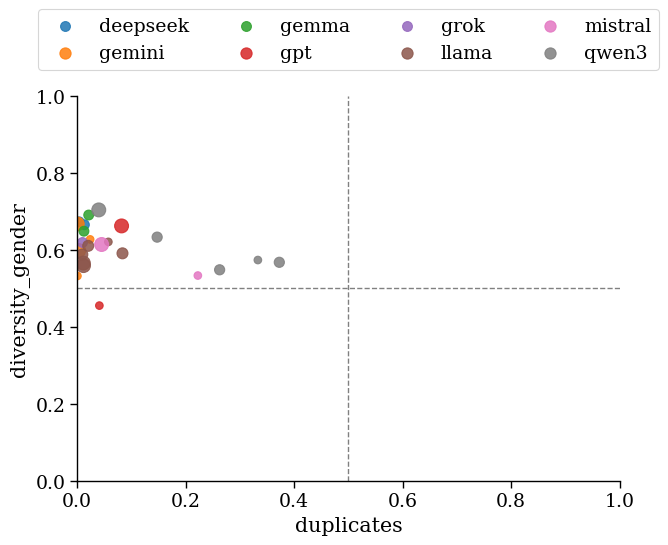

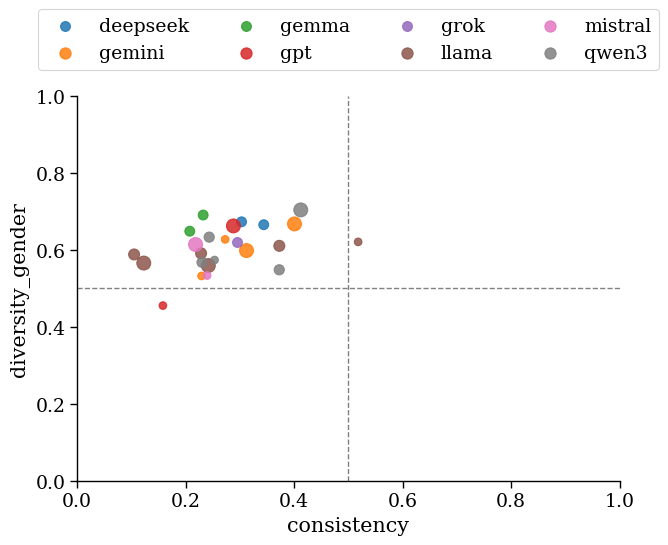

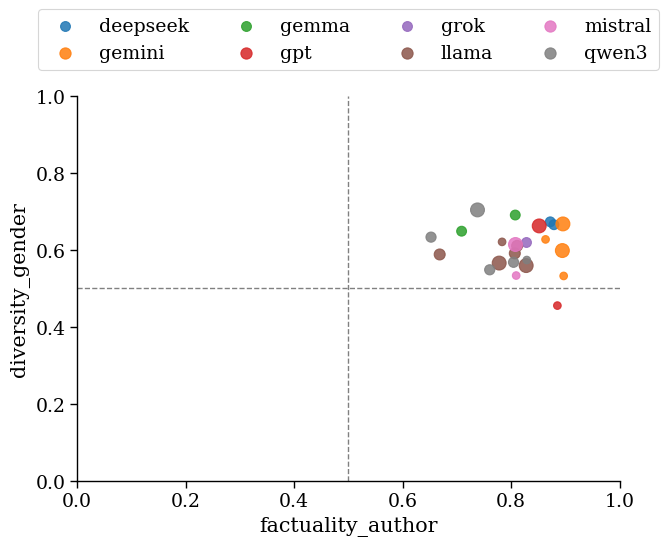

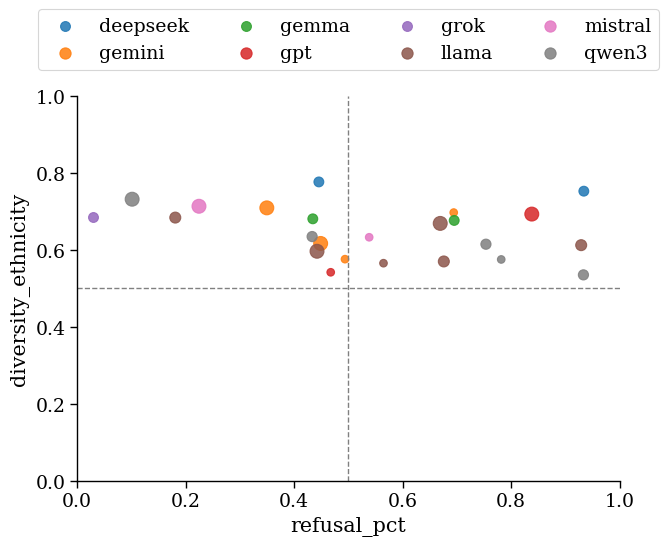

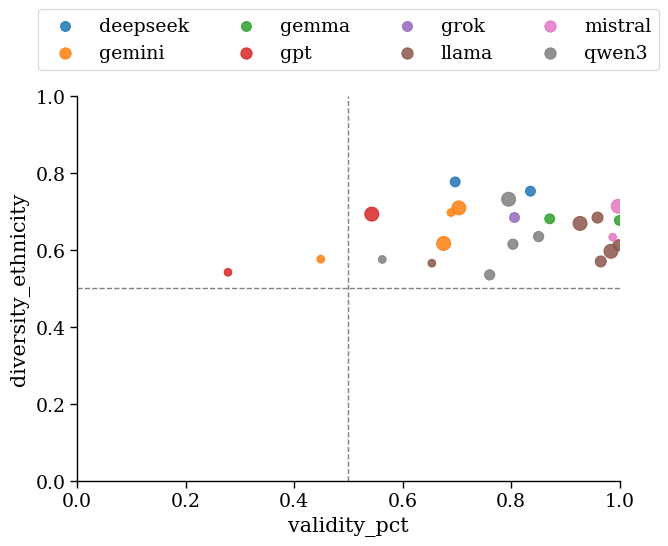

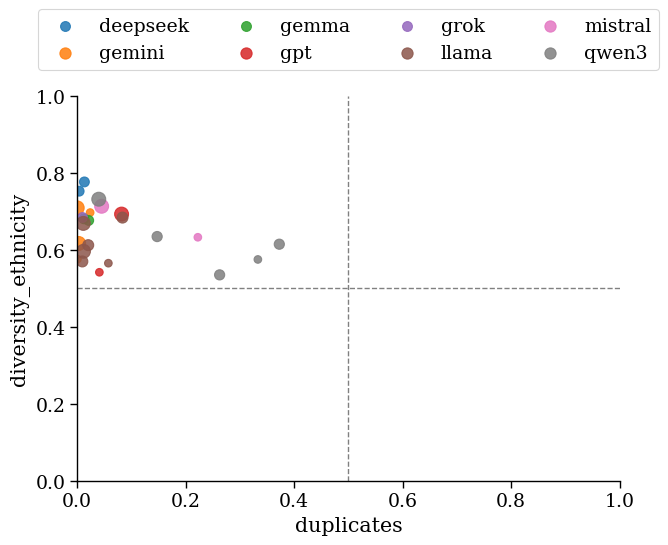

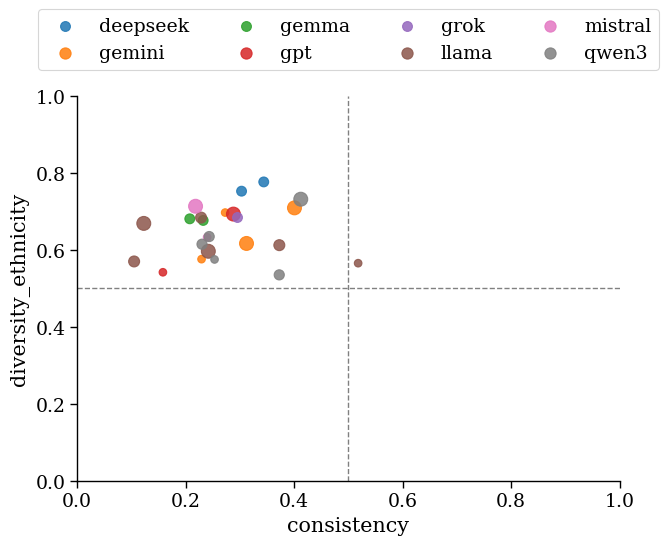

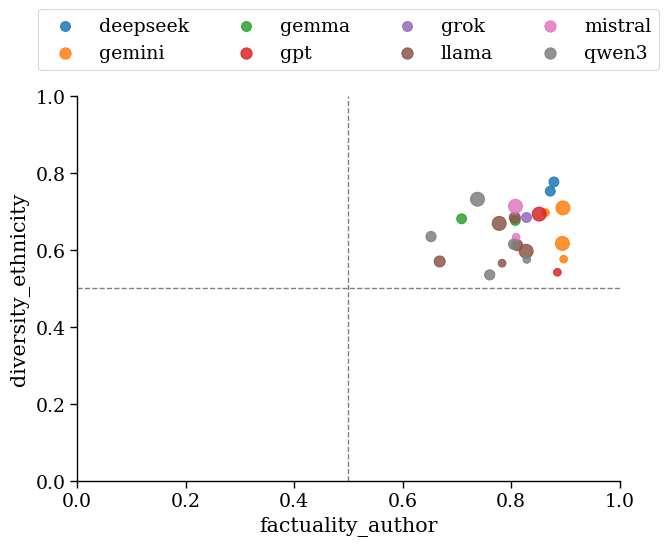

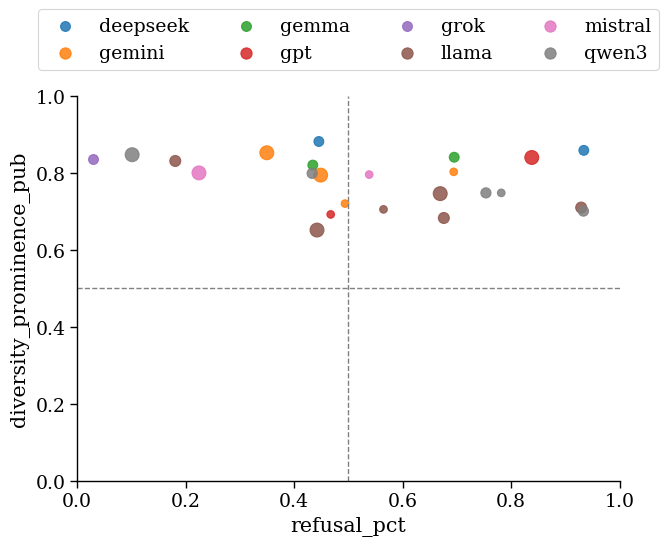

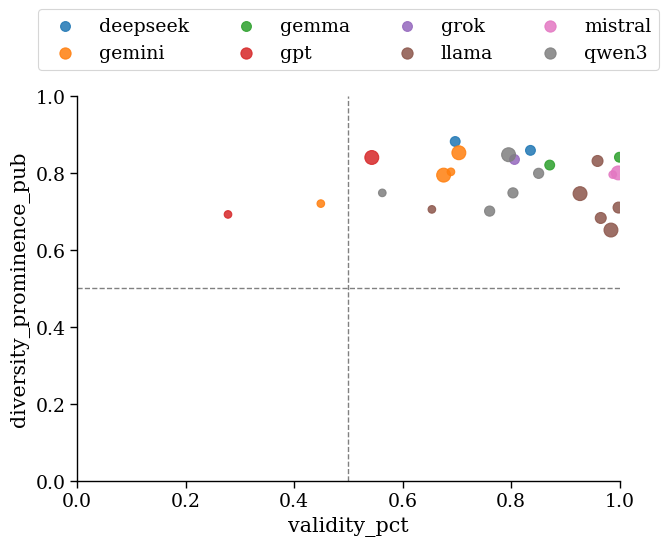

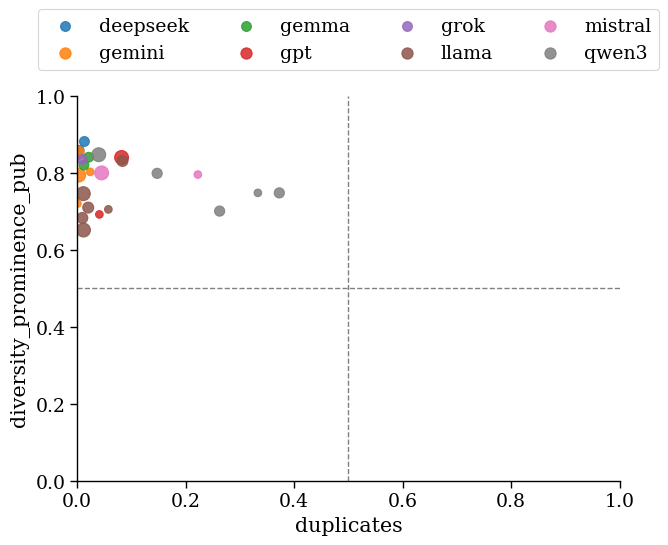

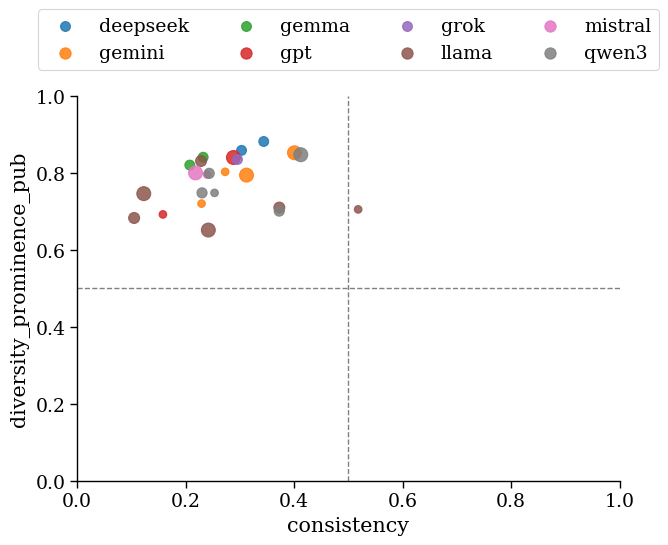

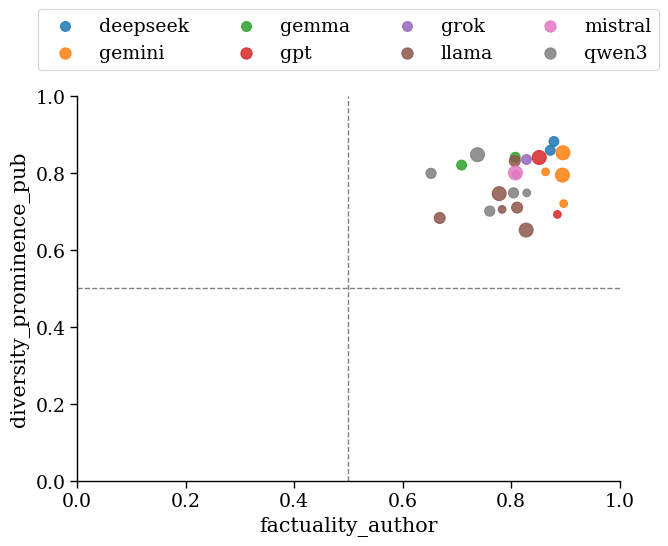

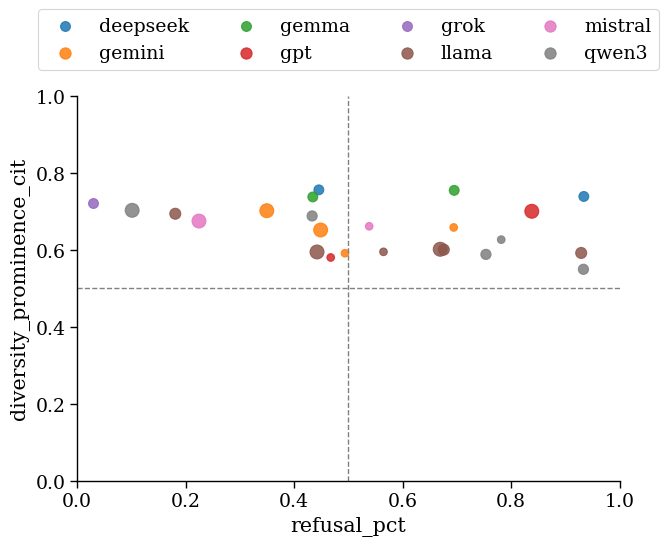

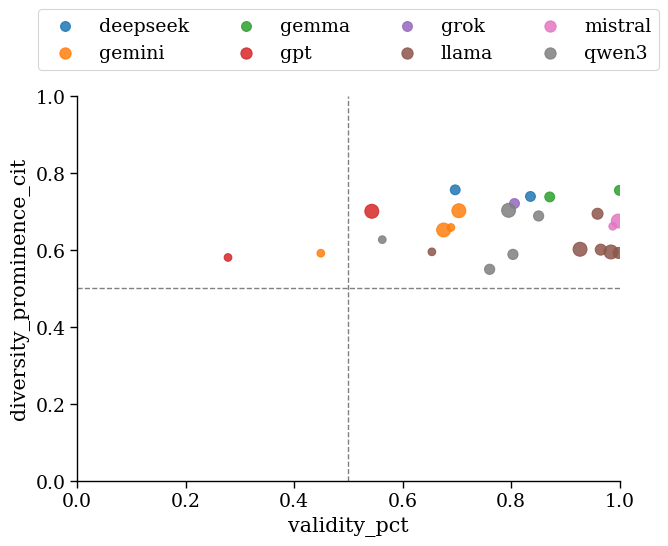

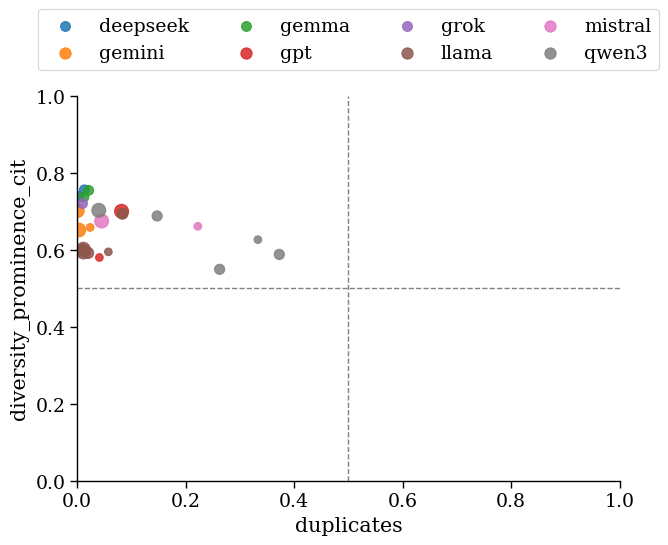

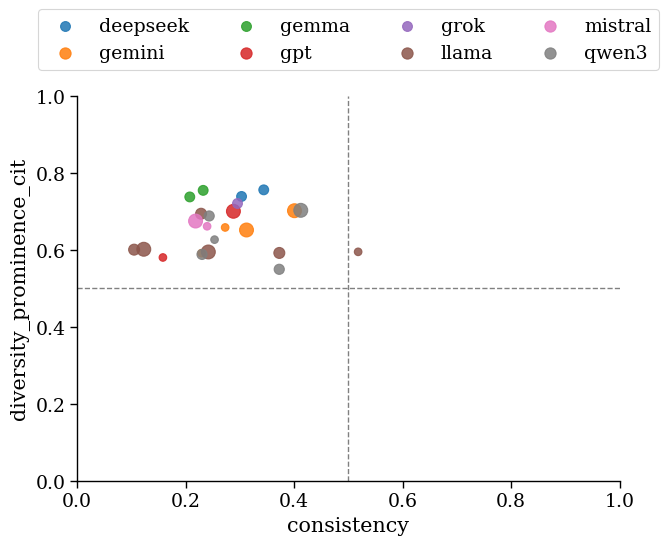

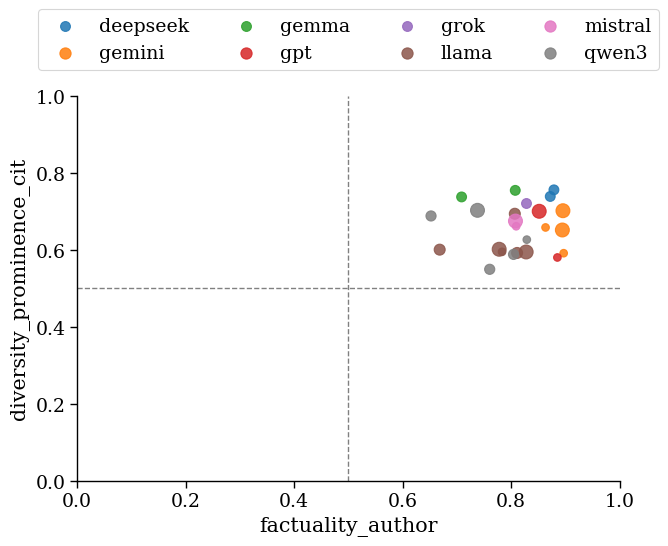

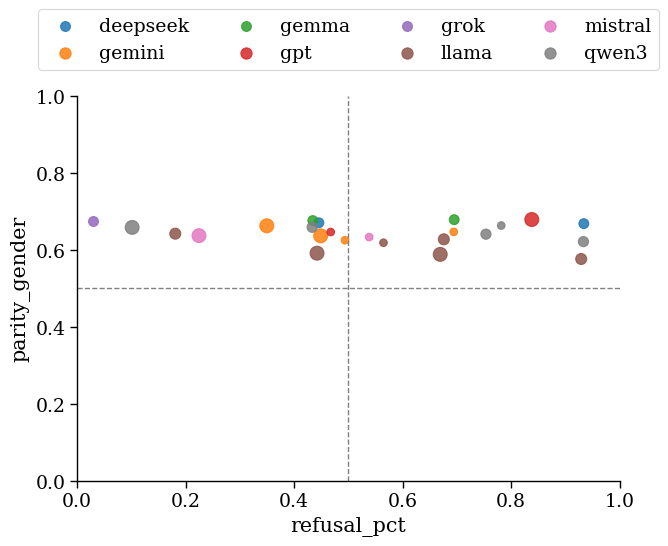

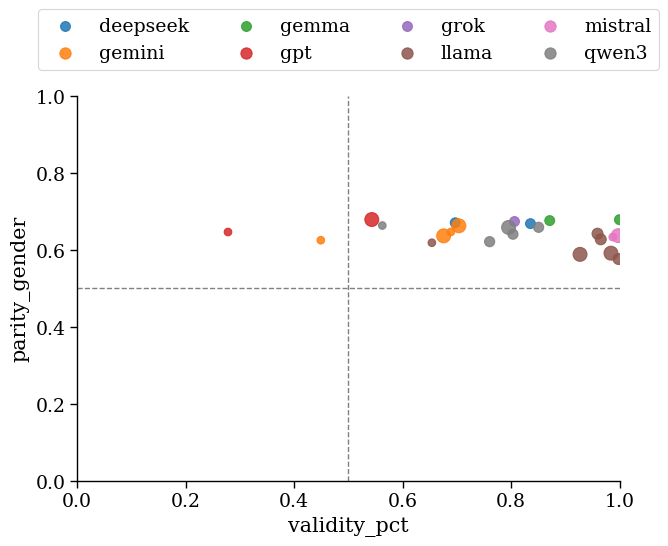

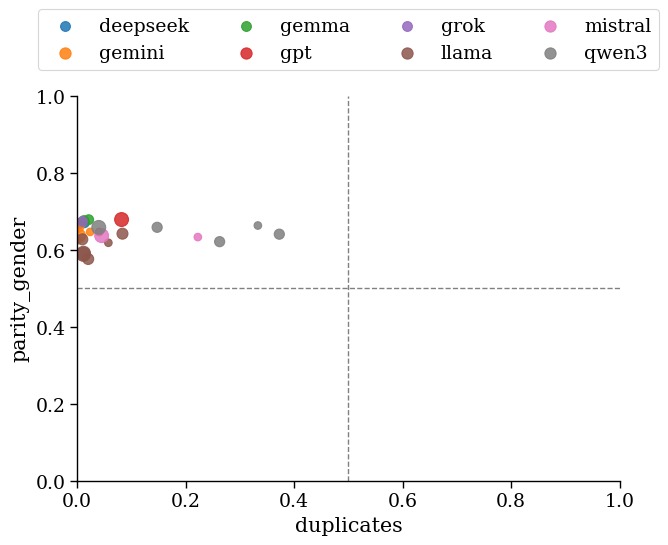

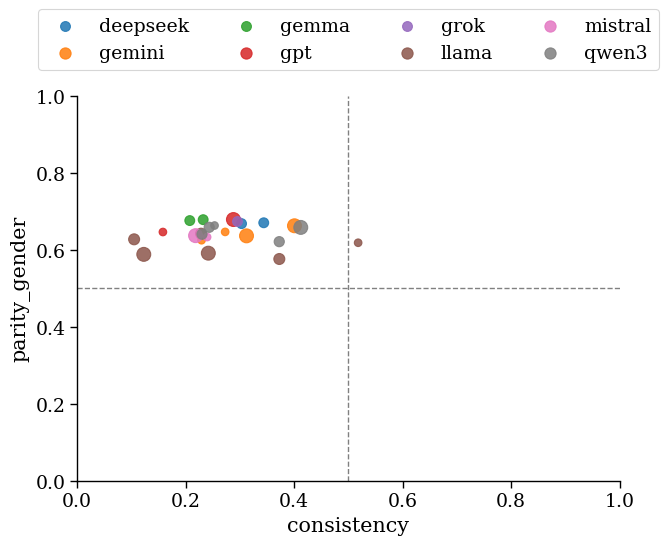

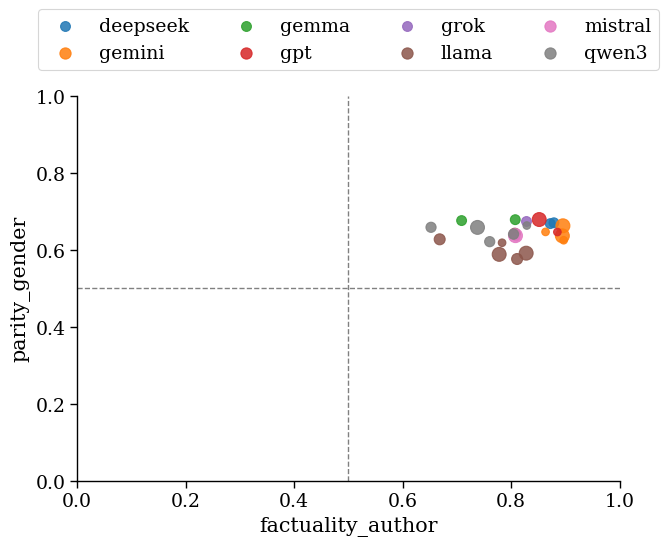

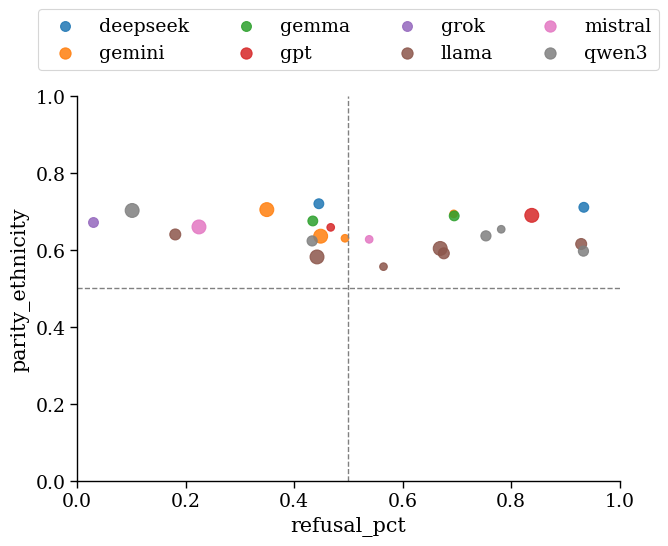

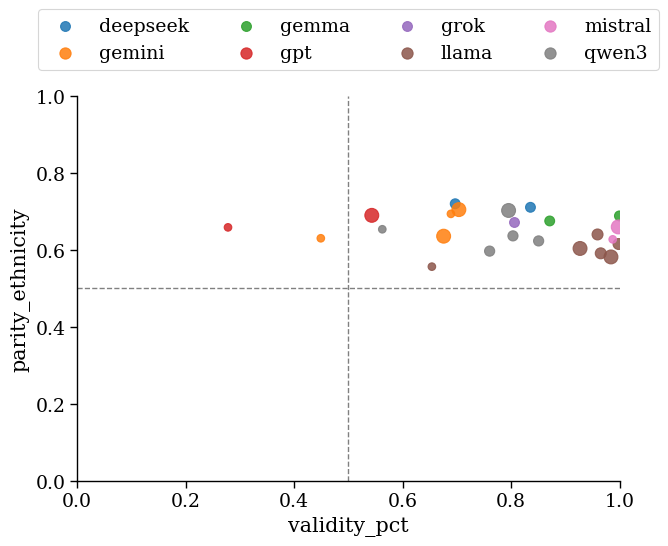

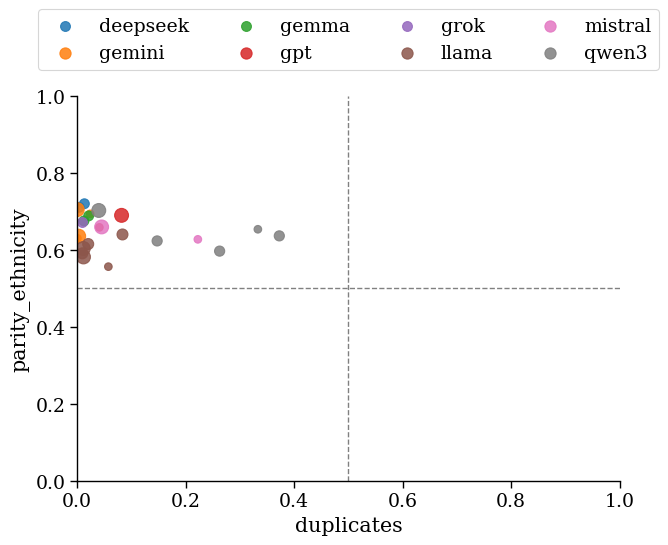

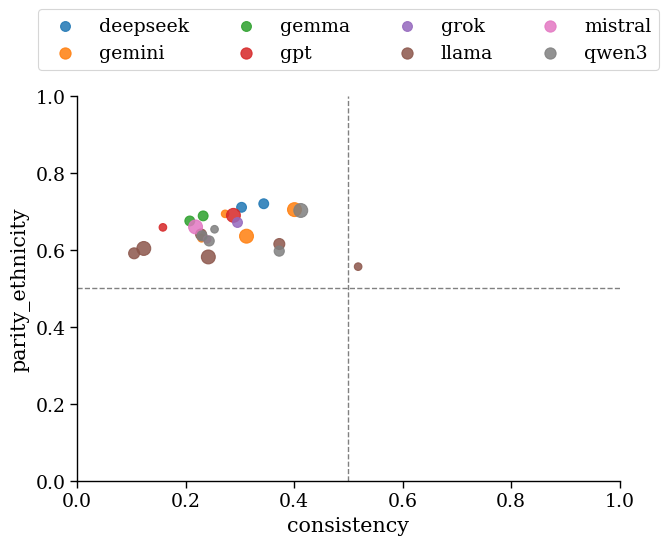

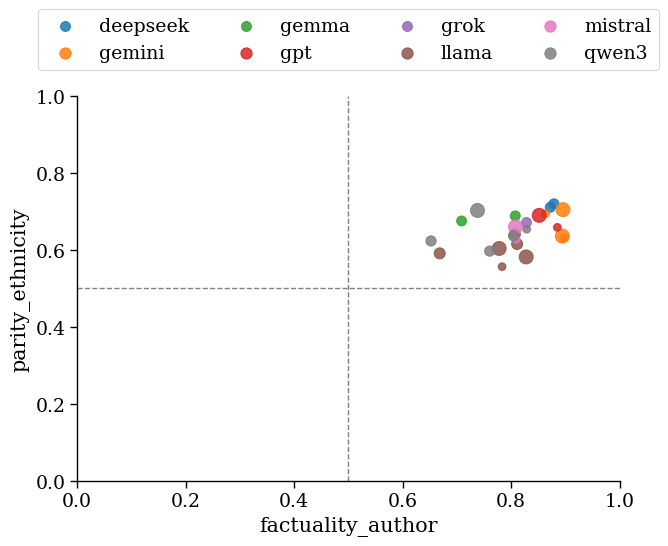

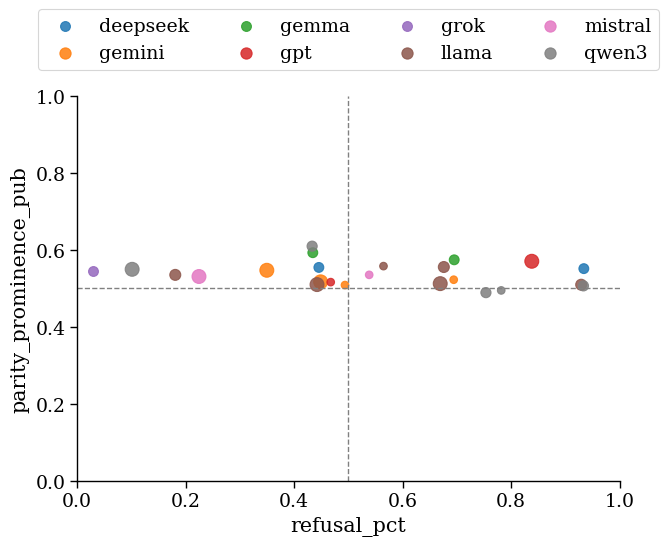

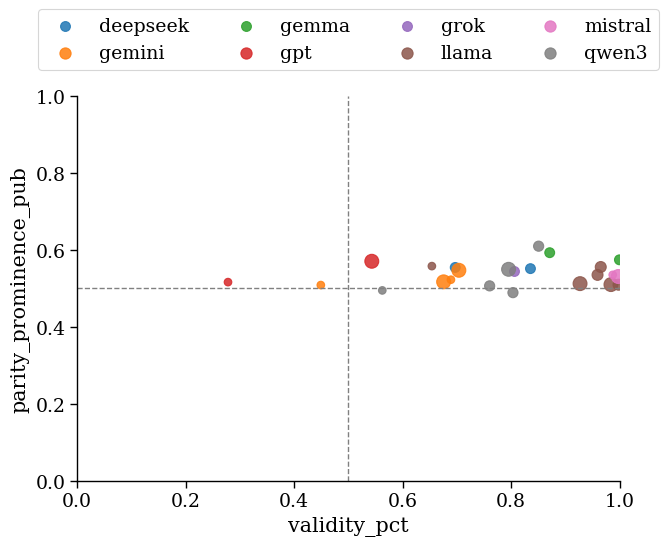

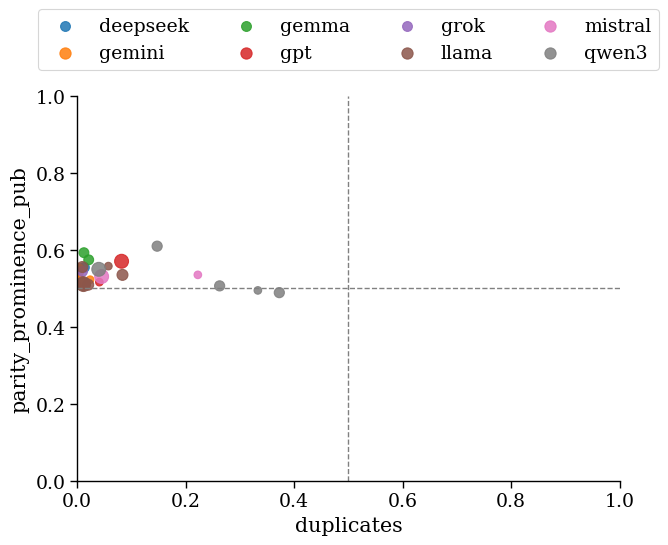

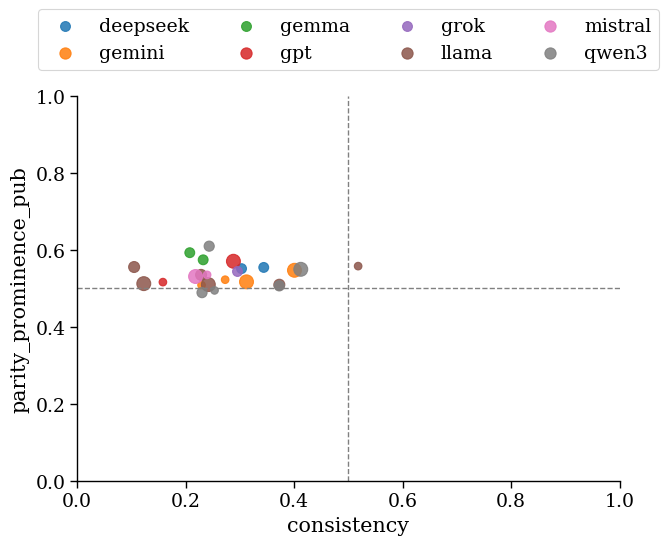

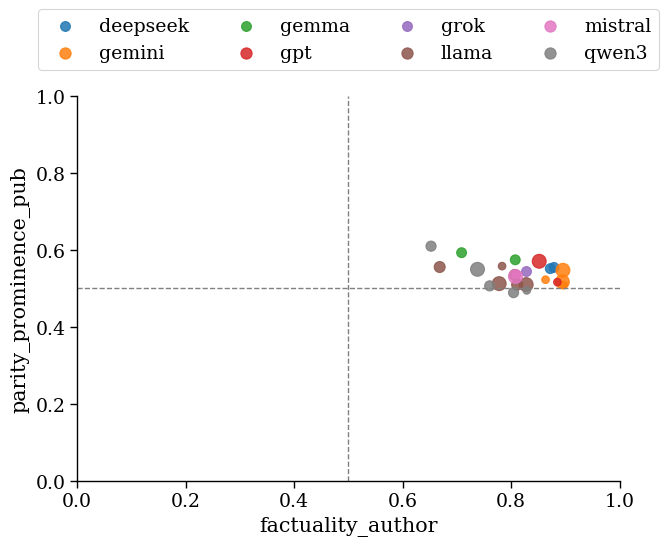

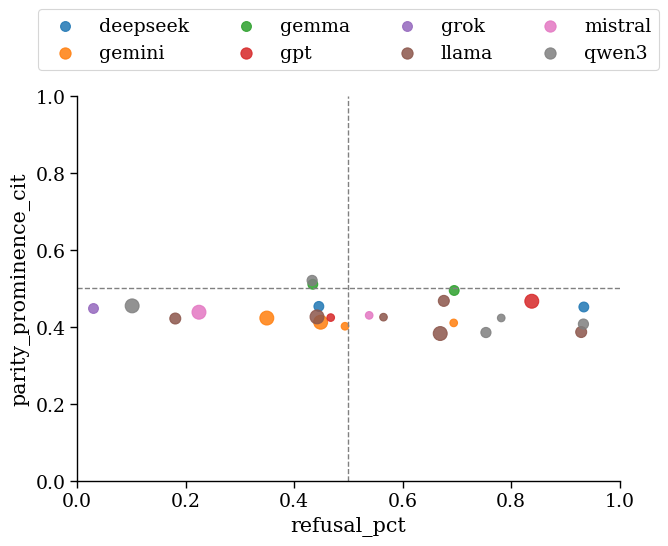

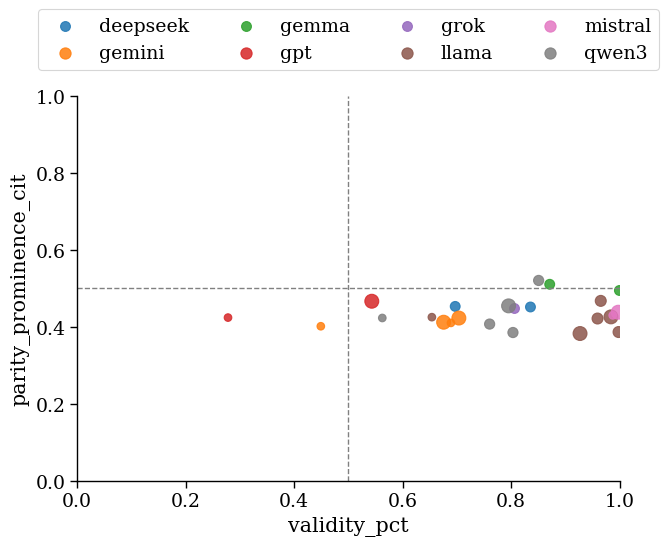

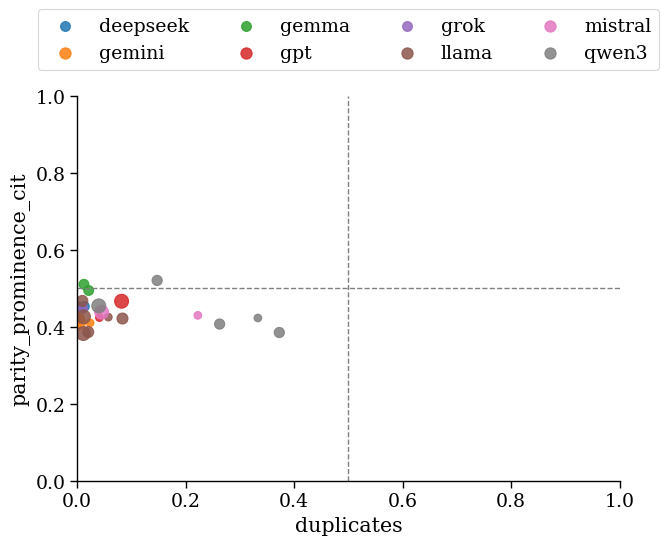

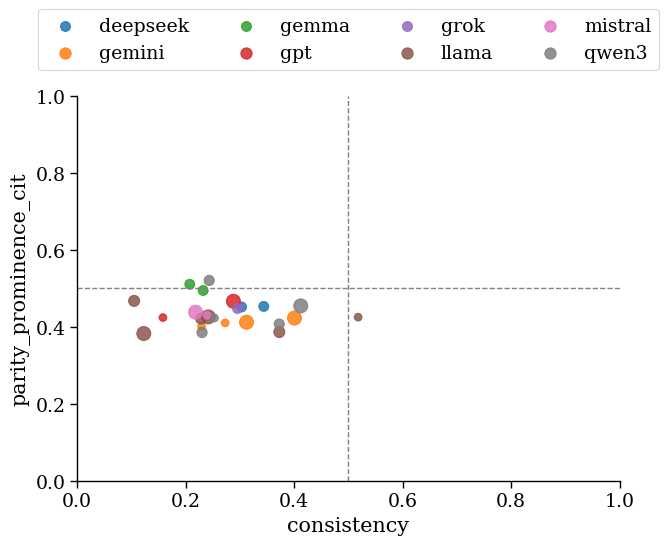

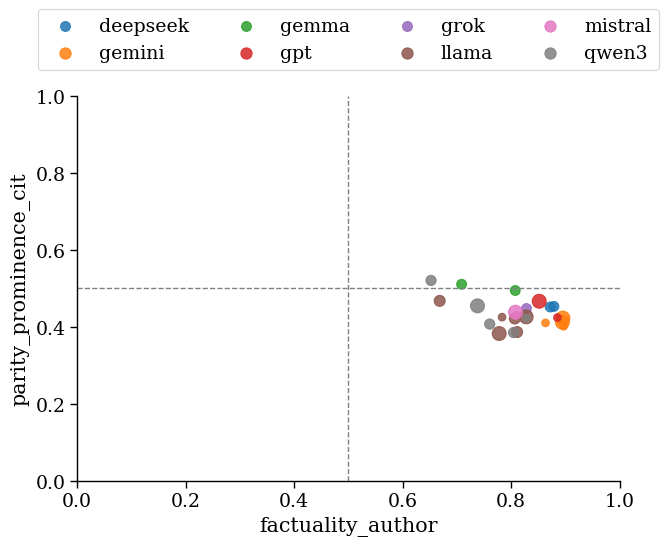

In [116]:
df_models = io.pd.DataFrame()
df_models = aggregators.aggregate_per_group(df_per_attempt, groupby, alpha=alpha_ci, metric_value_col=metric_value_col, metric_name_col=metric_name_col)
df_models = df_models[cols_order]


for metric_social in constants.BENCHMARK_SOCIAL_METRICS:
    for metric_technical in constants.BENCHMARK_TECHNICAL_METRICS:
        data = df_models.query("metric_name == @metric_social or metric_name == @metric_technical").copy()
        data = data.pivot(index='model', columns='metric_name', values='mean').reset_index()
        data.loc[:, 'family'] = data.model.apply(lambda x: x.split('-')[0])
        data = data.merge(df_per_attempt[['model', 'model_size']].drop_duplicates(), on='model', how='left')
        data.loc[:, 'size'] = data.model_size.apply(lambda x: 5 if x == 'S' else 20 if x == 'M' else 50 if x == 'L' else 100)

        spec = quadrants.SpaceSpec(
            x=metric_technical,
            y=metric_social,
            id_col="model",
            hue="family",             # optional
            size='size',
            legend_bbox_to_anchor=(0.5, 1.25),
            x_thr_mode='value',
            y_thr_mode='value',
            x_thr_value=0.5,
            y_thr_value=0.5,
            xlim=(0, 1),
            ylim=(0, 1),
            figsize=(7, 5)
        )

        fig, ax, quad_counts = quadrants.plot_quality_social_space(
            data,
            spec=spec,
            title=None,
            density="",           # set "hexbin" if heavy overlap
            jitter=0.,               # set small value like 0.005 if many collisions
            label_points=False,
            marker_size=50,
            show_quadrant_counts=False
        )

        # print(quad_counts)
        quadrants.plt.show()
        quadrants.plt.close()


## Social vs. Technical

In [117]:
# GROUP DATA
df_models = io.pd.DataFrame()





df_models = aggregators.aggregate_per_group(df_per_attempt, groupby, alpha=alpha_ci, metric_value_col=metric_value_col, metric_name_col=metric_name_col)
df_models = df_models[cols_order]
df_models.loc[:, 'metric_kind'] = df_models.metric_name.apply(lambda x: 'technical' if x in constants.BENCHMARK_TECHNICAL_METRICS else 'social')
df_models = df_models.groupby(['model','metric_kind'])['mean'].sum().reset_index()

df_models = df_models.pivot(index='model', columns='metric_kind', values='mean').reset_index()
df_models.loc[:, 'family'] = df_models.model.apply(lambda x: x.split('-')[0])
df_models = df_models.merge(df_per_attempt[['model', 'model_size']].drop_duplicates(), on='model', how='left')
df_models.loc[:, 'size'] = df_models.model_size.apply(lambda x: 5 if x == 'S' else 20 if x == 'M' else 50 if x == 'L' else 100)
df_models.head(2)

,model,social,technical,family,model_size,size
0,deepseek-chat-v3.1,7.782537,2.378039,deepseek,XL,100
1,deepseek-r1-0528,7.737524,2.947832,deepseek,XL,100


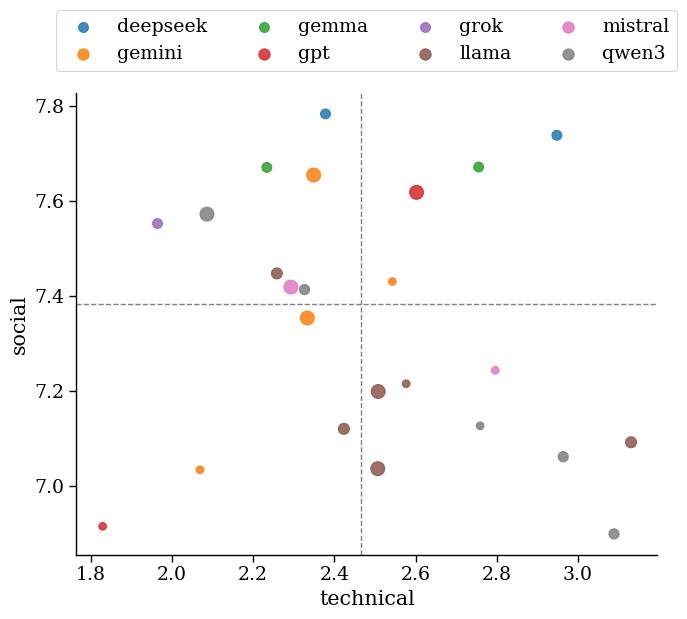

In [120]:
from libs.visuals import quadrants

spec = quadrants.SpaceSpec(
    x="technical",
    y="social",
    id_col="model",
    hue="family",             # optional
    size='size',
    legend_bbox_to_anchor=(0.5, 1.2),
    x_thr_mode='median',
    y_thr_mode='median',
)

fig, ax, quad_counts = quadrants.plot_quality_social_space(
    df_models,
    spec=spec,
    title=None,
    density="",           # set "hexbin" if heavy overlap
    jitter=0.,               # set small value like 0.005 if many collisions
    label_points=False,
    marker_size=50,
    show_quadrant_counts=False
)

# print(quad_counts)
quadrants.plt.show()
